# EPI warps

This notebook is for playing around with fieldmaps. Particularly, here we create a bspline-warp class that can be called by the [ndimage.geometrical_transform](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.ndimage.geometric_transform.html#scipy.ndimage.geometric_transform) to resample images through a nonlinear, BSpline-defined, transform.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import os.path as op
import nilearn as nil
import numpy as np
import nibabel as nb
from mriqc.viz import utils as mvu
from fmriprep.interfaces import fmap as fif
from scipy import ndimage as snd
from skimage.morphology import ball
from fmriprep.utils import bspline as fbsp
from statsmodels.robust.scale import mad

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Load a fieldmap and a mask

In [7]:
im = nb.as_closest_canonical(nb.load('fmap.nii.gz'))
mask_data = nb.as_closest_canonical(nb.load('fmap_mag_mask.nii.gz')).get_data().astype(np.uint8)
mask_data = snd.binary_erosion(mask_data, ball(3)).astype(np.uint8)

# This simulates a conversion from pixels to mm
newdata = im.get_data() * 0.1 * im.header.get_zooms()[1]
newdata -= np.median(newdata[mask_data>0])

newim = nb.Nifti1Image(newdata, im.affine, im.header)
newim.to_filename('fmap_mm.nii.gz')

vmin, vmax = np.percentile(newdata[mask_data>0], 1), np.percentile(newdata[mask_data>0], 99)
print(vmin, vmax, np.median(newdata[mask_data>0]), newdata[mask_data>0].min(), newdata[mask_data>0].max())

(-11.496506624221801, 5.6621785306930592, 0.0, -27.247684, 15.377636)


In [3]:
bspobj = fbsp.BSplineFieldmap('fmap_mm.nii.gz', weights=mask_data)
# bspobj = BSplineFieldmap('fmap_mm.nii.gz', knots_zooms=[60., 60., 48.])
bspobj.fit()
bspobj.get_smoothed().to_filename('fmap_smoothed_new.nii.gz')

[2017-02-10 15:35:49.222341] Evaluating tensor-product cubic BSpline on 754152 points, 576 control points
[2017-02-10 15:37:54.465848] Finished BSpline evaluation, (754152, 576)
[2017-02-10 15:37:54.470976] Starting least-squares fitting using 256116 unmasked points
[2017-02-10 15:38:08.915419] Finished least-squares fitting


u'mosaic.svg'

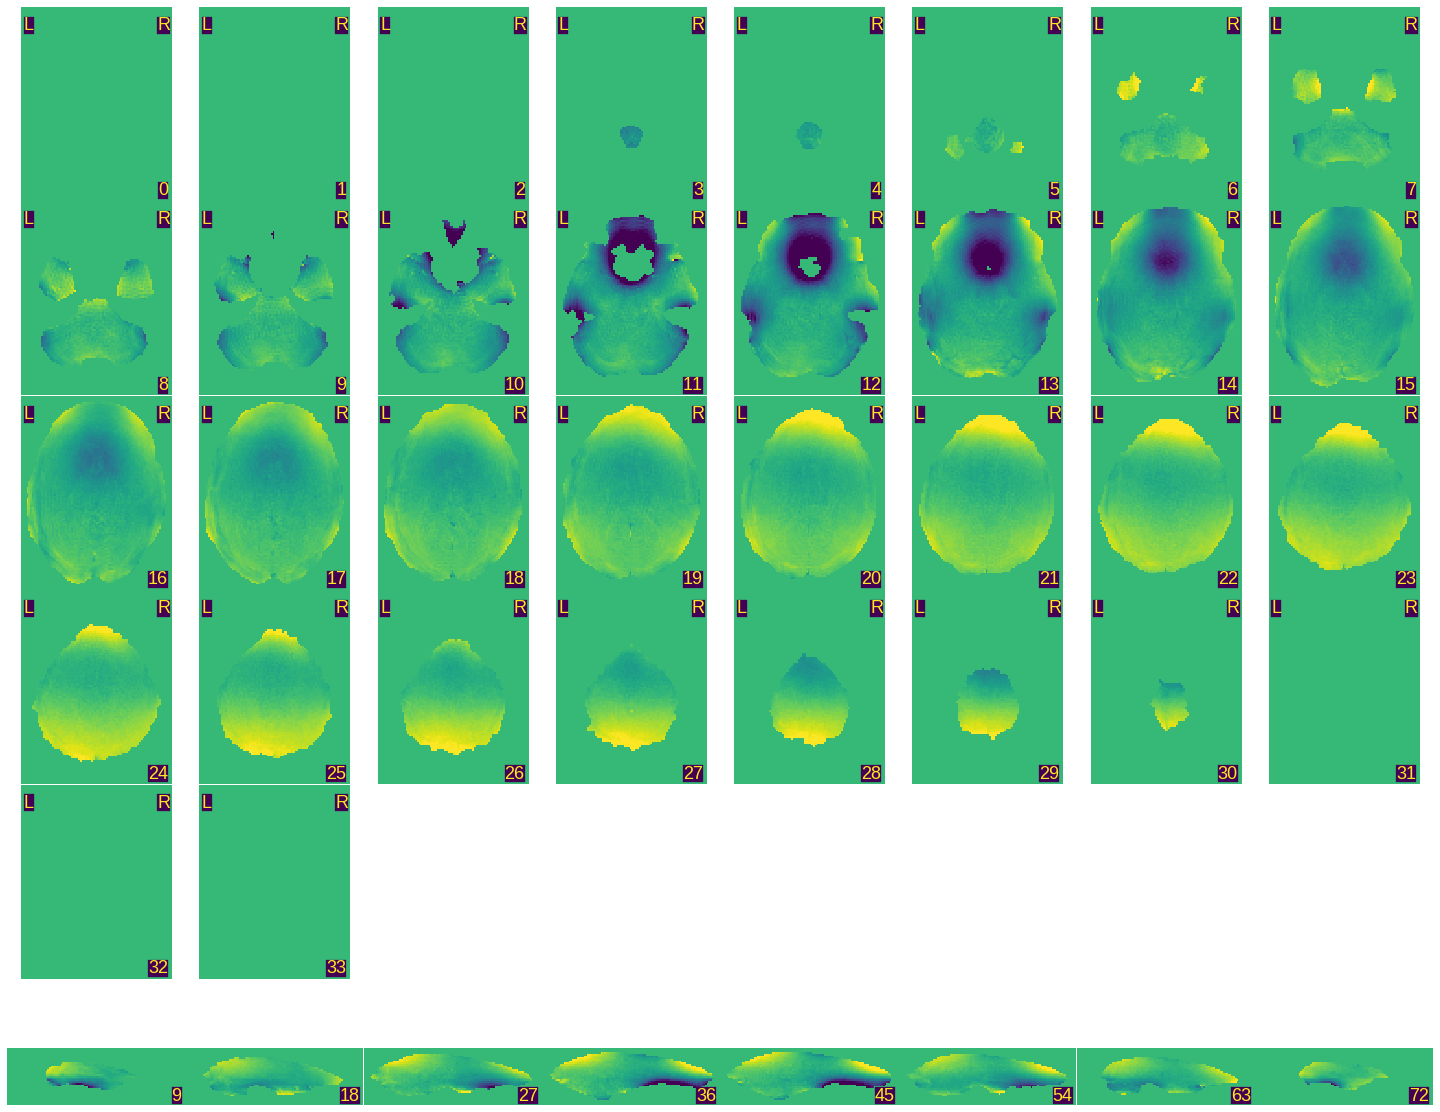

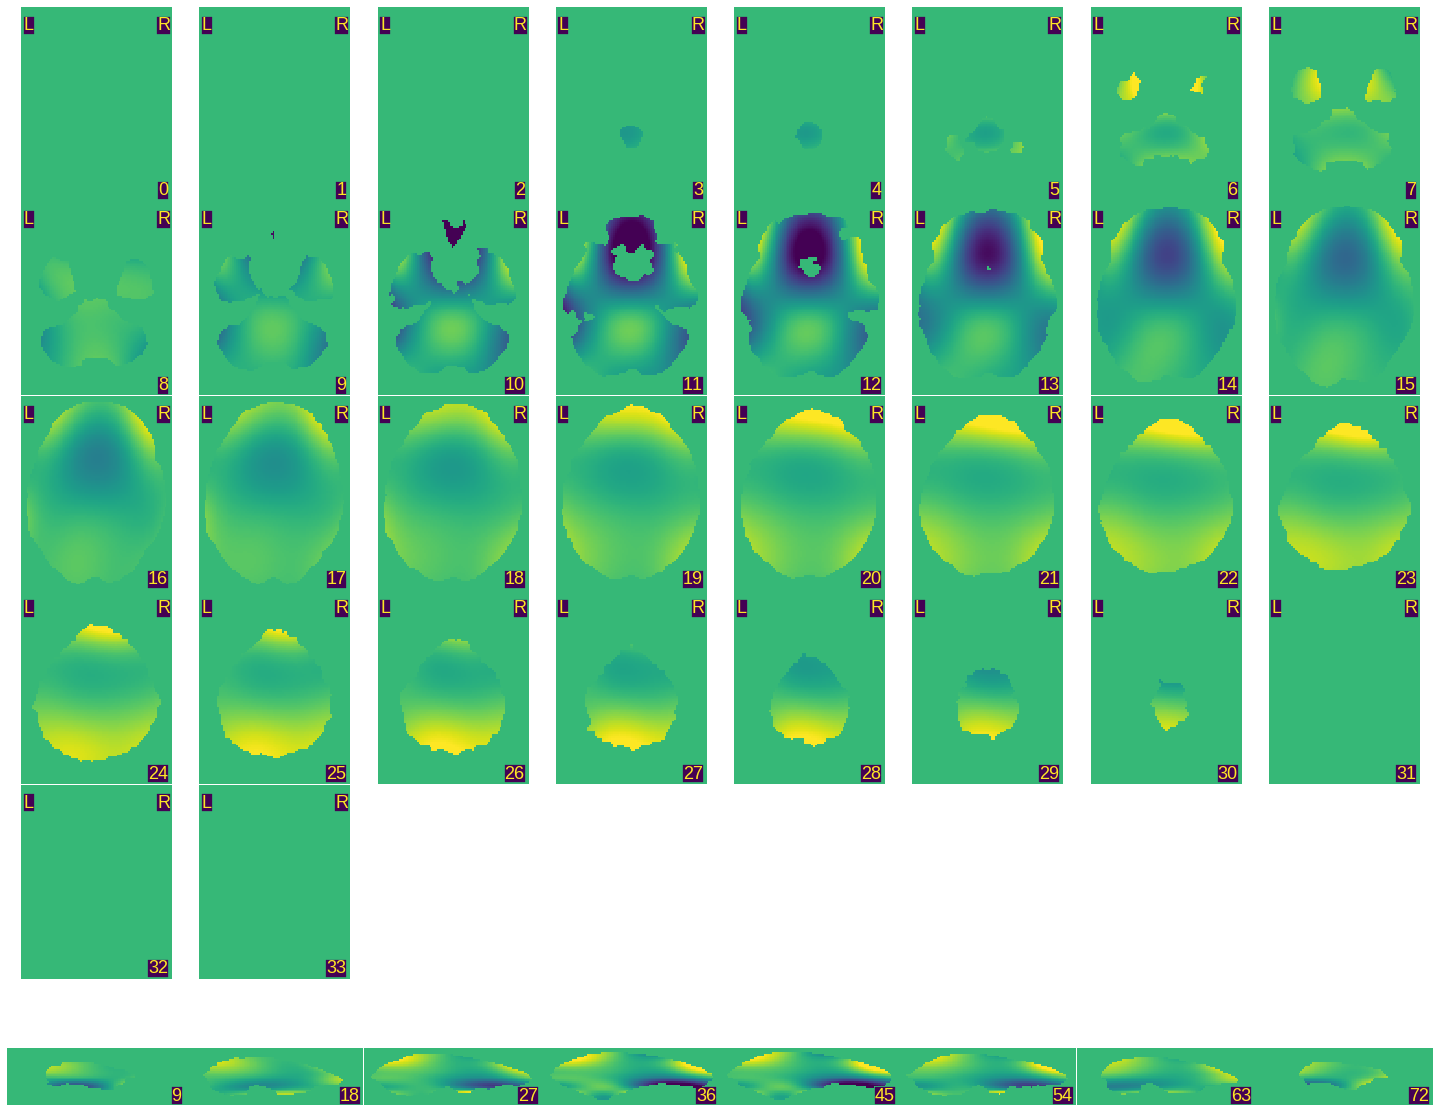

In [11]:
smoothed1 = nb.load('fmap_smoothed_new.nii.gz').get_data()
mvu.plot_mosaic(mask_data * newdata, bbox_mask_file='fmap_mag_mask.nii.gz', cmap='viridis', vmin=vmin, vmax=vmax)
mvu.plot_mosaic(mask_data * smoothed1, bbox_mask_file='fmap_mag_mask.nii.gz', cmap='viridis', vmin=vmin, vmax=vmax)

0.455623 0.0118953


u'mosaic.svg'

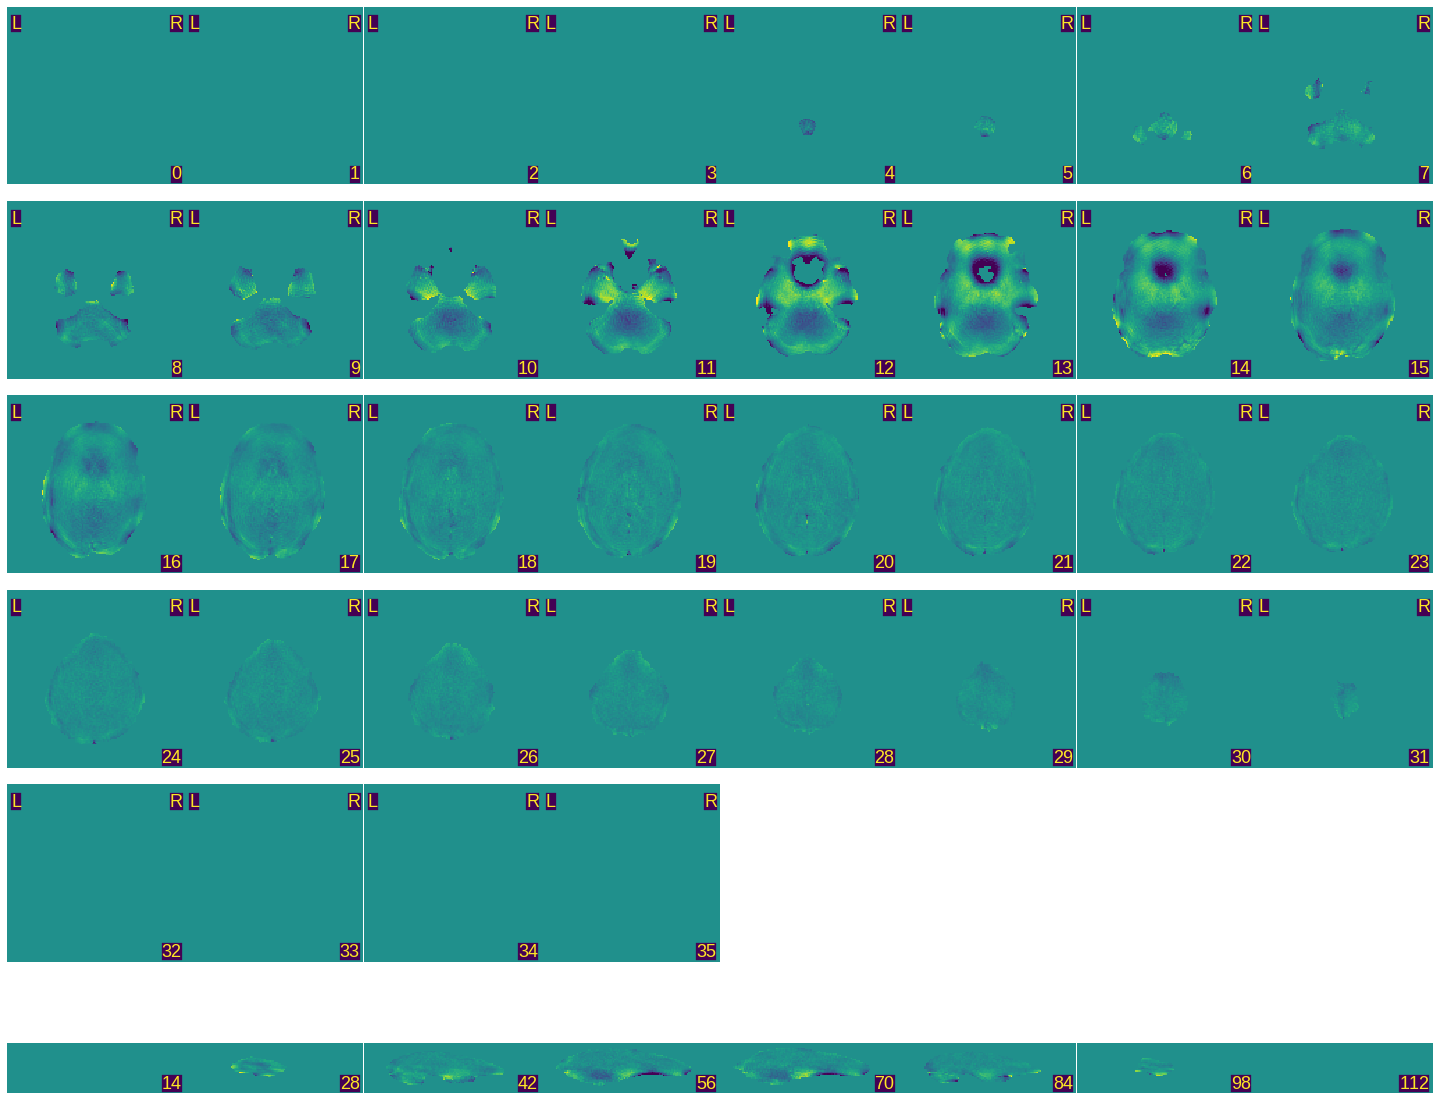

In [12]:
diffmap = newdata - smoothed1
sderror = mad(diffmap[mask_data > 0])
print sderror, np.median(diffmap[mask_data > 0])
# Mask out values 2sigmas away from the mean
mvu.plot_mosaic(mask_data * diffmap, cmap='viridis', vmin=-10*sderror, vmax=10*sderror)

In [ ]:
bspobj2 = fbsp.BSplineFieldmap(nb.Nifti1Image(diffmap, im.affine, im.header), weights=mask_data,
                               knots_zooms=[20., 30., 8.])
bspobj2.fit()

[2017-02-10 16:20:04.030602] Evaluating tensor-product cubic BSpline on 754152 points, 3220 control points


In [ ]:
smoothed2 = bspobj2.get_smoothed().get_data()
mvu.plot_mosaic(mask_data * smoothed2, cmap='viridis', vmin=-10*sderror, vmax=10*sderror)
mvu.plot_mosaic(mask_data * smoothed1, cmap='viridis', vmin=vmin, vmax=vmax)

final = smoothed2 + smoothed1
print(smoothed1[mask_data > 0].min(), smoothed1[mask_data > 0].max())
print(smoothed2[mask_data > 0].min(), smoothed2[mask_data > 0].max())
print(final[mask_data>0].min(), final[mask_data>0].max())

In [ ]:
mvu.plot_mosaic(mask_data * final, cmap='viridis')

err1 = newdata - final
mvu.plot_mosaic(mask_data * err1, cmap='viridis', vmin=-0.5, vmax=0.5)
print(err1[mask_data > 0].max(), err1[mask_data > 0].min())

In [ ]:
bspobj.invert()
bspobj.get_inverted().to_filename('fmap_smoothed_new_inverted.nii.gz')
mvu.plot_mosaic('fmap_smoothed_new_inverted.nii.gz', cmap='viridis')

print(nb.load('fmap_smoothed_new.nii.gz').get_data()[mask_data>0].min(), nb.load('fmap_smoothed_new.nii.gz').get_data()[mask_data>0].max())
print(nb.load('fmap_smoothed_new_inverted.nii.gz').get_data()[mask_data>0].min(), nb.load('fmap_smoothed_new_inverted.nii.gz').get_data()[mask_data>0].max())

In [ ]:
in_data = nb.as_closest_canonical(nb.load('fmap_mag.nii.gz')).get_data()
# in_data = np.zeros_like(in_data)
# in_data[::10, :, :] = 1
# in_data[1::10, :, :] = 1
# in_data[:, ::10, :] = 1
# in_data[:, 1::10, :] = 1

mvu.plot_mosaic(in_data)
newmag = bspobj.interp(in_data, inverse=False)
mvu.plot_mosaic(newmag.get_data())
newrevmag = bspobj.interp(in_data, inverse=True, fwd_pe=False)
mvu.plot_mosaic(newrevmag.get_data())
ident = bspobj.interp(newmag.get_data())
mvu.plot_mosaic(ident.get_data() * mask_data)

In [ ]:
def select_biggest(in_mask):
    from scipy import ndimage as ndi
    import numpy as np
    map_labels, n_labels = ndi.label(in_mask)
    
    sizes = []
    for label in range(1, n_labels):
        sizes.append(np.sum(in_mask[map_labels == label]))

    biggest = list(range(1, n_labels))[np.argmax(sizes)]

    out_mask = np.zeros_like(in_mask, dtype=np.uint8)
    out_mask[map_labels == biggest] = 1
    return out_mask

In [ ]:
# data_path = op.expanduser('~/Data/ds054_zeynep/')
data_path = op.expanduser('~/Data/rewardBeastBIDS')
fieldmap = op.join(data_path, 'sub-269', 'fmap', 'sub-269_fieldmap.nii.gz')

In [ ]:
mvu.plot_mosaic(op.join(data_path, 'sub-269', 'fmap', 'sub-269_fieldmap.nii.gz'))

In [ ]:
estimate = fif.FieldEnhance(in_file=fieldmap, despike=False)
res = estimate.run()
mvu.plot_mosaic(res.outputs.out_file)

In [ ]:
im = nb.as_closest_canonical(nb.load(fieldmap))
zooms = im.header.get_zooms()
data = np.squeeze(im.get_data())

In [ ]:
from matplotlib import pyplot as plt
datanorm = data.copy() - data.min()
datanorm = (datanorm / datanorm.max()) * 2 - 1
plt.imshow(datanorm[..., 14])

In [ ]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
entr_img = entropy(datanorm[..., 14], disk(3))
plt.imshow(entr_img)

In [ ]:
from skimage import restoration as sir
newimg = sir.denoise_wavelet(datanorm)
plt.imshow(newimg[..., 14])

In [ ]:
plt.imshow(sir.denoise_nl_means(datanorm[..., 15], h=0.5, patch_size=20))

In [ ]:
from skimage import segmentation as sis
from skimage.future import graph as sig

markers = np.zeros_like(datanorm, dtype=int)
markers[50:70, 50:70, 12:16] = 128
markers[np.abs(datanorm) > 0.8] = 255
rwseg = sis.random_walker(datanorm, markers)


In [ ]:
plt.imshow(rwseg[..., 14])

In [ ]:
from matplotlib import cm
datanorm = data.copy() - np.median(data)
datanorm[datanorm < 0] *= -1.0
plt.imshow(datanorm[..., 14], cmap=cm.get_cmap('Greys_r'))

In [ ]:
plt.hist(data.reshape(-1))

In [ ]:
nii = nb.as_closest_canonical(nb.load(op.join(data_path, 'sub-269', 'fmap', 'sub-269_magnitude.nii.gz')))
magdata = np.squeeze(nii.get_data())[..., 0]
mvu.plot_mosaic(magdata)

In [ ]:
from scipy import ndimage
from skimage.morphology import ball
thres = np.percentile(magdata, 70)
mag_mask = np.zeros_like(magdata)
mag_mask[magdata > thres] = 1

mag_mask = ndimage.binary_dilation(mag_mask, ball(3)).astype(int)
mag_mask = select_biggest(mag_mask)
mvu.plot_mosaic(mag_mask * data, cmap='viridis')

nb.Nifti1Image(mag_mask * data, im.affine, im.header).to_filename('fmap.nii.gz')

In [ ]:
bspl_img, bspl_coeff = fif.bspl_smoothing('fmap.nii.gz', knot_space=[20., 20., 12.])
bspl_img.to_filename('fmap_bspl.nii.gz')
nb.Nifti1Image(bspl_img.get_data() * mag_mask, im.affine, im.header).to_filename('fmap_bspl_masked.nii.gz')
mvu.plot_mosaic('fmap_bspl_masked.nii.gz', cmap='viridis')

In [ ]:
immagmask = nb.as_closest_canonical(nb.load('fmap_mag_mask.nii.gz'))

diff = (data - bspl_img.get_data()) * immagmask.get_data().astype(np.uint8)
mvu.plot_mosaic(bspl_img.get_data() * immagmask.get_data().astype(np.uint8), cmap='viridis_r')
print(diff.max(), diff.min(), np.mean(diff[immagmask.get_data().astype(np.uint8)>0]), diff[immagmask.get_data().astype(np.uint8)>0].std())

print(data.max(), data.min(), np.mean(data[immagmask.get_data().astype(np.uint8)>0]), data[immagmask.get_data().astype(np.uint8)>0].std())
print(bspl_img.get_data().max(), bspl_img.get_data().min(), np.mean(bspl_img.get_data()[immagmask.get_data().astype(np.uint8)>0]), bspl_img.get_data()[immagmask.get_data().astype(np.uint8)>0].std())

In [ ]:
dwell_time = 0.02
fmap_mm = bspl_img.get_data() * dwell_time * zooms[1]
print(fmap_mm.max(), fmap_mm.min(), np.mean(fmap_mm[immagmask.get_data().astype(np.uint8)>0]), fmap_mm[immagmask.get_data().astype(np.uint8)>0].std())

ijk = np.array(np.where(fmap_mm < np.inf))
xyz = np.array(ijk).T * np.array(zooms[:3])[np.newaxis, :3]
xyz[..., 1] += fmap_mm.reshape(-1)

ijk_2 = np.mgrid[0:fmap_mm.shape[0],0:fmap_mm.shape[1], 0:fmap_mm.shape[2]].reshape(3, -1).T

ijk_h = np.hstack((ijk_2, np.array([1.0] * len(ijk_2))[..., np.newaxis]))
print(ijk_h[0, :], ijk_h[-1, :])

In [ ]:
from dipy.segment.mask import median_otsu
mag_mask, mask = median_otsu(magdata, 1, 1)
mvu.plot_mosaic(mag_mask)

In [ ]:
from sklearn.decomposition import PCA
X = np.stack((magdata.reshape(-1), data.reshape(-1)), -1)
X.shape

In [ ]:
pca = PCA(n_components=1)
res = pca.fit(X)

In [ ]:
newimage = pca.transform(X)

In [ ]:
newmag = newimage[:, 0].reshape(magdata.shape)
mvu.plot_mosaic(newmag)

In [ ]:
mvu.plot_mosaic('/home/oesteban/Data/B0P/B0P-session12-set3-echo1.nii')

In [ ]:
bspobj.interp([10.4, 10.0, 0.0])

In [ ]:
print(bspobj._fmapxyz.min(0), bspobj._fmapxyz.max(0))
print(bspobj._knots_xyz.min(0), bspobj._knots_xyz.max(0))
print(bspobj._fmapnii.header.get_zooms())

In [ ]:
def bspl_smoothing(fmapnii, masknii=None, knot_space=[18., 18., 20.]):
    """
    A 3D BSpline smoothing of the fieldmap
    """
    from builtins import str, bytes
    from scipy.linalg import pinv2

    data = fmapnii.get_data()
    zooms = fmapnii.header.get_zooms()

    # Calculate hi-res i
    ijk = np.where(data < np.inf)
    xyz = np.array(ijk).T * np.array(zooms)[np.newaxis, :3]

    # Calculate control points
    xyz_max = xyz.max(axis=0)
    knot_dims = np.ceil(xyz_max / knot_space) + 2
    bspl_grid = np.zeros(tuple(knot_dims.astype(int)))
    bspl_ijk = np.where(bspl_grid == 0)
    bspl_xyz = np.array(bspl_ijk).T * knot_space[np.newaxis, ...]
    bspl_max = bspl_xyz.max(axis=0)
    bspl_xyz -= 0.5 * (bspl_max - xyz_max)[np.newaxis, ...]

    points_ijk = ijk
    points_xyz = xyz

    # Mask if provided
    if masknii is not None:
        if isinstance(masknii, (str, bytes)):
            masknii = nb.load(masknii)
        data[masknii.get_data() <= 0] = 0
        points_ijk = np.where(masknii.get_data() > 0)
        points_xyz = np.array(points_ijk).T * np.array(zooms)[np.newaxis, :3]


    print('[%s] Evaluating tensor-product cubic-bspline on %d points' % (dt.now(), len(points_xyz)))
    # Calculate design matrix
    X = tbspl_eval(points_xyz, bspl_xyz, knot_space)
    print('[%s] Finished, bspline grid has %d control points' % (dt.now(), len(bspl_xyz)))
    Y = data[points_ijk]


    # Fit coefficients
    print('[%s] Starting least-squares fitting' % dt.now())
    # coeff = (pinv2(X.T.dot(X)).dot(X.T)).dot(Y) # manual way (seems equally slow)
    coeff = np.linalg.lstsq(X, Y)[0]
    print('[%s] Finished least-squares fitting' % dt.now())
    bspl_grid[bspl_ijk] = coeff
    aff = np.eye(4)
    aff[:3, :3] = aff[:3, :3] * knot_space[..., np.newaxis]
    coeffnii = nb.Nifti1Image(bspl_grid, aff, None)

    # Calculate hi-res design matrix:
    # print('[%s] Evaluating tensor-product cubic-bspline on %d points' % (dt.now(), len(xyz)))
    # Xinterp = tbspl_eval(xyz, bspl_xyz, knot_space)
    # print('[%s] Finished, start interpolation' % dt.now())

    # And interpolate
    newdata = np.zeros_like(data)
    newdata[points_ijk] = X.dot(coeff)
    newnii = nb.Nifti1Image(newdata, fmapnii.affine, fmapnii.header)

    return newnii, coeffnii

def tbspl_eval(points, knots, zooms):
    from fmriprep.utils.maths import bspl
    points = np.array(points)
    knots = np.array(knots)
    vbspl = np.vectorize(bspl)

    coeffs = []
    ushape = (knots.shape[0], 3)
    for p in points:
        u_vec = (knots - p[np.newaxis, ...]) / zooms[np.newaxis, ...]
        c = vbspl(u_vec.reshape(-1)).reshape(ushape).prod(axis=1)
        coeffs.append(c)

    return np.array(coeffs)
